#**XG Boost**
Change runtime type to T4 GPU

In [ ]:
# skip
%pip install -r ../requirements.txt

In [ ]:
from google.colab import files
uploaded = files.upload()

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.io import loadmat
import seaborn as sns
import numpy as np
import pandas as pd
import xgboost as xgb

#**LOAD MNIST**

In [ ]:
mnist = loadmat('./MNIST.mat')

# Extract data
X_train_full = mnist['train_fea']
y_train_full = mnist['train_gnd'].ravel()
X_test = mnist['test_fea']
y_test = mnist['test_gnd'].ravel()

# Split training into train and validation (55k train, 5k val)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=5000, random_state=42)

# shift labels to 0-9
y_train = y_train - 1
y_val = y_val - 1
y_test = y_test - 1

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")


Training set: (55000, 784), (55000,)
Validation set: (5000, 784), (5000,)
Test set: (10000, 784), (10000,)


#**MODEL FITTING AND EARLY STOPPING**


## Fitting model

In [ ]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

# 1. Initialize K-Fold
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

cv_scores = []
fold = 1

print(f"Starting {k}-Fold Cross-Validation...")

# 2. Iterate through folds using the FULL training data (X_train_full, y_train_full)
# Note: Ensure y_train_full is already shifted to 0-9 range if needed (the original code did this after split)
y_train_full_shifted = y_train_full - 1

for train_index, val_index in skf.split(X_train_full, y_train_full_shifted):
    # Split data for this fold
    X_train_fold, X_val_fold = X_train_full[train_index], X_train_full[val_index]
    y_train_fold, y_val_fold = y_train_full_shifted[train_index], y_train_full_shifted[val_index]

    # Early Stopping
    early_stop = xgb.callback.EarlyStopping(
        rounds=20,
        metric_name='mlogloss',
        data_name='validation_0',
        save_best=True,
        min_delta=1e-3    # (default 1e-2) Improvement threshold for continued training, decreasing to prevent premature stopping or increase to mitigate overfitting
    )

    # Re-initialize classifier to reset it (optional but safer)
    clf = xgb.XGBClassifier(
        tree_method="hist",
        n_estimators=2000,
        eval_metric=["mlogloss", "merror"],
        device='cuda',        # Ensure GPU is on
        learning_rate=0.2,
        max_depth=6,
        callbacks=[early_stop]
    )

    # Fit with early stopping using this fold's validation set
    clf.fit(
        X_train_fold, y_train_fold,
        eval_set=[(X_val_fold, y_val_fold),
                  (X_test, y_test)],
        verbose=False
    )

    # Evaluate
    # clf.best_iteration is automatically used for prediction if early stopping occurred
    score = clf.score(X_val_fold, y_val_fold)
    cv_scores.append(score)

    print(f"Fold {fold}/{k} Accuracy: {score:.4f} (Best Iteration: {clf.best_iteration})")
    fold += 1

# 3. Final Average Performance
print(f"\nMean CV Accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")

Starting 5-Fold Cross-Validation...
Fold 1/5 Accuracy: 0.9802 (Best Iteration: 159)
Fold 2/5 Accuracy: 0.9801 (Best Iteration: 162)
Fold 3/5 Accuracy: 0.9746 (Best Iteration: 136)
Fold 4/5 Accuracy: 0.9748 (Best Iteration: 158)
Fold 5/5 Accuracy: 0.9752 (Best Iteration: 147)

Mean CV Accuracy: 0.9769 (+/- 0.0026)


#**Performance Analysis**

In [ ]:
# Extract best test error (at the best iteration found by early stopping)
# best_iteration is an index, so we access that specific epoch
results = clf.evals_result()

best_iter = clf.best_iteration
best_test_error = results['validation_1']['merror'][best_iter]
best_test_error_percent = best_test_error * 100

# Get hyperparameters
n_trees = best_iter + 1 # +1 because iteration is 0-indexed
max_depth = clf.max_depth # Accessed from the classifier instance

# Format the summary string
summary_text = f"test error {best_test_error_percent:.2f}%, {n_trees} trees, maximum depth {max_depth}"

# Print to verify
print(summary_text)

# Write to text file
with open("xgboost_summary.txt", "w") as f:
    f.write(summary_text)

print("Summary saved to xgboost_summary.txt")

test error 2.20%, 148 trees, maximum depth 6
Summary saved to xgboost_summary.txt


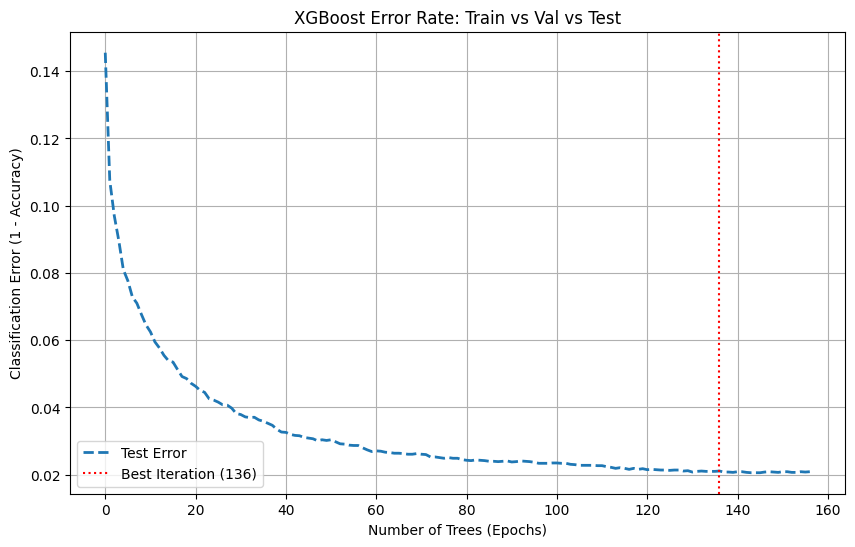

In [ ]:
# Re-create the callback for this specific run
early_stop_plot = xgb.callback.EarlyStopping(
    rounds=20,
    metric_name='mlogloss',
    data_name='validation_1', # Monitor validation set (index 1) for early stopping
    save_best=True,
    min_delta=1e-3
)

clf = xgb.XGBClassifier(
    tree_method="hist",
    n_estimators=2000,
    eval_metric=["mlogloss", "merror"],
    device='cuda',
    learning_rate=0.2,
    max_depth=6,
    callbacks=[early_stop_plot]
)

# CRITICAL: Pass 3 datasets to eval_set so you get validation_0, validation_1, and validation_2
clf.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val), (X_test, y_test)],
    verbose=False
)

# Now extract results
results = clf.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# Now your plotting code will work because all 3 keys exist
plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_2']['merror'], label='Test Error', linewidth=2, linestyle='--')

# SAVE BEFORE SHOWING
plt.savefig("test_error_vs_trees.pdf", format="pdf", bbox_inches="tight")
plt.savefig("test_error_vs_trees.eps", format="eps", bbox_inches="tight")

plt.axvline(x=clf.best_iteration, color='r', linestyle=':', label=f'Best Iteration ({clf.best_iteration})')
plt.xlabel('Number of Trees (Epochs)')
plt.ylabel('Classification Error (1 - Accuracy)')
plt.title('XGBoost Error Rate: Train vs Val vs Test')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
import pickle
from sklearn.metrics import zero_one_loss

# -------------------------------
# Load the trained model
# -------------------------------
with open("xgb_pixel_clean.pkl", "rb") as f:
    clf = pickle.load(f)

# -------------------------------
# Compute Errors
# -------------------------------
# Training error
y_train_pred = clf.predict(X_train)
train_error = zero_one_loss(y_train, y_train_pred)

# Validation error
y_val_pred = clf.predict(X_val)
val_error = zero_one_loss(y_val, y_val_pred)

# Test error
y_test_pred = clf.predict(X_test)
test_error = zero_one_loss(y_test, y_test_pred)

print(f"Training Error: {train_error*100:.2f}%")
print(f"Validation Error: {val_error*100:.2f}%")
print(f"Test Error: {test_error*100:.2f}%")

Test error: 0.9976


In [ ]:
model_l = pickle.load(open("xgb_lenet_clean.pkl", "rb"))

mnist_l = scipy.io.loadmat("MNIST-LeNet5.mat")
Xtest_l = mnist_l["test_fea"]
ytest_l = mnist_l["test_gnd"].ravel()

y_pred_l = model_l.predict(Xtest_l)

test_error_l = 1 - accuracy_score(ytest_l, y_pred_l)
print("LeNet-5 feature model test error:", test_error_l)

LeNet-5 feature model test error: 0.9986


#**Generate confusion matrix**
evaluating on the test set

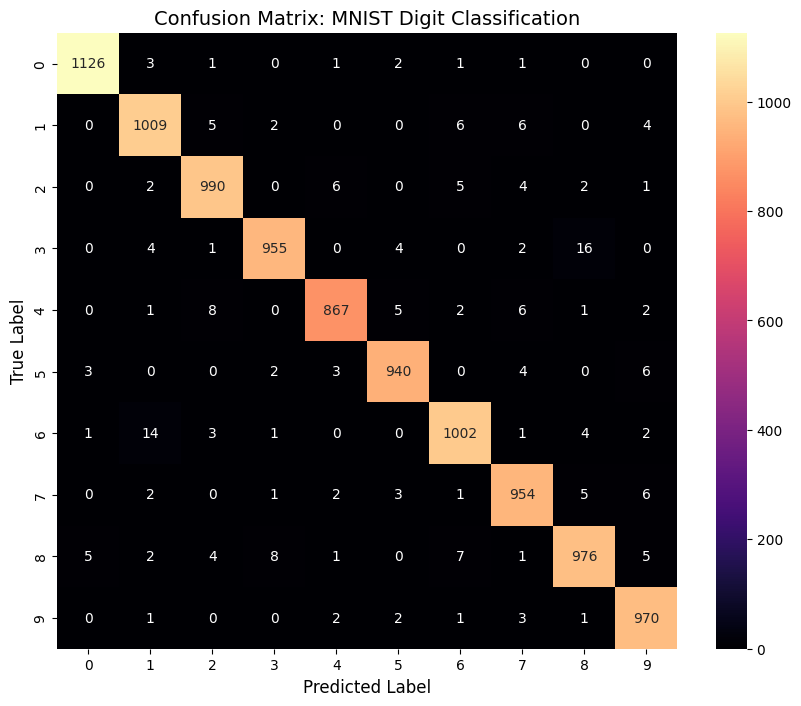


Classification Report:

              precision    recall  f1-score   support

           0     0.9921    0.9921    0.9921      1135
           1     0.9721    0.9777    0.9749      1032
           2     0.9783    0.9802    0.9792      1010
           3     0.9856    0.9725    0.9790       982
           4     0.9830    0.9720    0.9775       892
           5     0.9833    0.9812    0.9822       958
           6     0.9776    0.9747    0.9761      1028
           7     0.9715    0.9795    0.9755       974
           8     0.9711    0.9673    0.9692      1009
           9     0.9739    0.9898    0.9818       980

    accuracy                         0.9789     10000
   macro avg     0.9788    0.9787    0.9787     10000
weighted avg     0.9789    0.9789    0.9789     10000



In [ ]:
y_test_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
            cm,
            cmap="magma",
            annot=True,
            fmt="d",
            cbar=True,
        )
plt.title('Confusion Matrix: MNIST Digit Classification', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_test, y_test_pred, digits=4))

In [ ]:
# We need to extract the parameters from our trained model (pickle):
import pickle
import xgboost as xgb

# Load the saved model
model = pickle.load(open("xgb_pixel_clean.pkl", "rb"))
# Get all hyperparameters
params = model.get_params()
print(params)


{'objective': 'multi:softprob', 'base_score': None, 'booster': None, 'callbacks': [<xgboost.callback.EarlyStopping object at 0x7d67fa5fb9b0>], 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': 'cuda', 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'mlogloss', 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.2, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 6, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 2000, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': 'hist', 'validate_parameters': None, 'verbosity': None}


#**Load LeNet5**

In [ ]:
# -------------------------------
# Load LeNet5 Features
# -------------------------------
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load LeNet5 features
LeNet = loadmat('./MNIST-LeNet5.mat')

print("Keys in .mat file:", LeNet.keys())

# Extract data
X_train_full = LeNet['train_fea']
y_train_full = LeNet['train_gnd'].ravel()
X_test = LeNet['test_fea']
y_test = LeNet['test_gnd'].ravel()

# Split training into train and validation sets (55k train, 5k val)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=5000, random_state=42
)

# Shift labels to 0-9
y_train = y_train - 1
y_val = y_val - 1
y_test = y_test - 1

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")


#**MODEL FITTING AND EARLY STOPPING**

In [ ]:
# -------------------------------
# Define XGBoost Classifier with Early Stopping
# -------------------------------
early_stop = xgb.callback.EarlyStopping(
    rounds=50,            # stop if no improvement for 50 rounds
    metric_name='merror', # classification error
    data_name='validation_1',
    save_best=True
)

clf = xgb.XGBClassifier(
    tree_method="hist",
    n_estimators=2000,
    eval_metric="merror",
    learning_rate=0.2,
    max_depth=6,
    device='cuda',
    callbacks=[early_stop]
)


In [ ]:
# -------------------------------
# Fit XGBoost Model
# -------------------------------
# Include train, validation, and test in eval_set
clf.fit(
    X_train, y_train,
    eval_set=[
        (X_train, y_train),  # validation_0
        (X_val, y_val),      # validation_1
        (X_test, y_test)     # validation_2
    ],
    verbose=False
)

# Save evaluation results
results = clf.evals_result()
print("Finished training.")


Finished training.


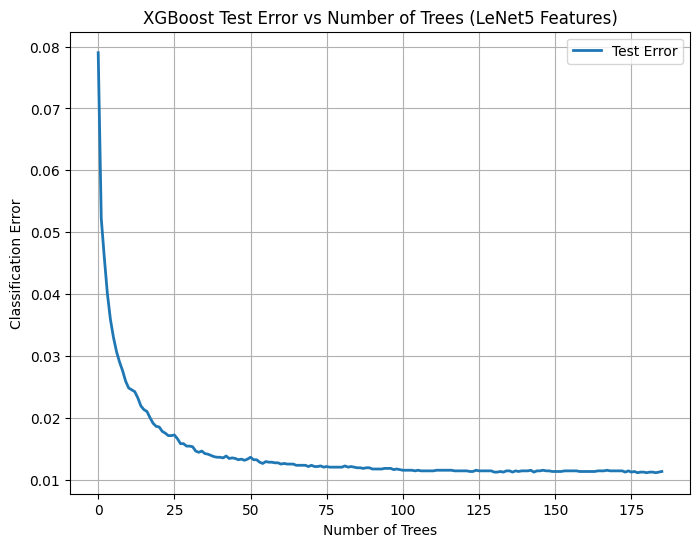

In [ ]:
# -------------------------------
# Plot Test Error vs Number of Trees
# -------------------------------
test_error_curve = results['validation_2']['merror']
trees = range(len(test_error_curve))

plt.figure(figsize=(8,6))
plt.plot(trees, test_error_curve, linewidth=2, label="Test Error")
plt.xlabel("Number of Trees")
plt.ylabel("Classification Error")
plt.title("XGBoost Test Error vs Number of Trees (LeNet5 Features)")
plt.grid(True)
plt.legend()
plt.savefig("lenet_test_error.pdf", format="pdf", dpi=300)
plt.savefig("lenet_test_error.eps", format="eps", dpi=300)
plt.show()


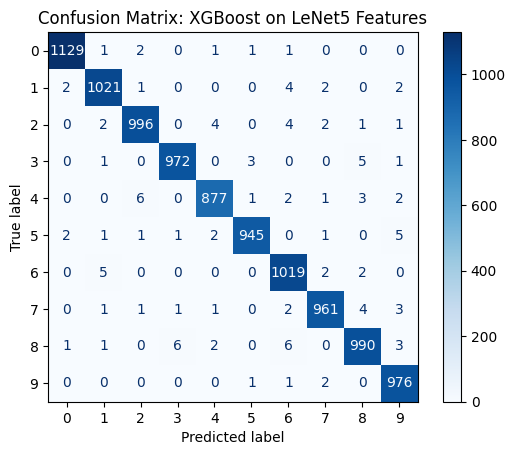

In [ ]:
# -------------------------------
# Confusion Matrix on Test Set
# -------------------------------
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix: XGBoost on LeNet5 Features")
plt.show()


In [ ]:
# -------------------------------
# 6. Print Best Test Error and Number of Trees
# -------------------------------
best_iteration = clf.best_iteration  # best iteration determined by early stopping
best_test_error = test_error_curve[best_iteration]

print(f"Best Test Error: {best_test_error*100:.2f}%, Number of Trees: {best_iteration}")
print(f"Other Hyperparameters: max_depth=6, learning_rate=0.2, tree_method='hist'")


Best Test Error: 1.14%, Number of Trees: 135
Other Hyperparameters: max_depth=6, learning_rate=0.2, tree_method='hist'


In [ ]:
import pickle

# Load the trained model
model = pickle.load(open("xgb_lenet_clean.pkl", "rb"))

# Get the best iteration (number of trees selected by early stopping)
best_iteration = model.get_booster().best_iteration
print("Best number of trees (best_iteration):", best_iteration)

params = model.get_params()
print("Max depth:", params['max_depth'])
print("Learning rate:", params['learning_rate'])


Best number of trees (best_iteration): 64
Max depth: 6
Learning rate: 0.2
